Q1: Train shape: (10450, 12)
Q1: Test  shape: (2613, 9)

Q1: Train info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10450 non-null  object 
 1   season      10450 non-null  int64  
 2   holiday     10450 non-null  int64  
 3   workingday  10450 non-null  int64  
 4   weather     10450 non-null  int64  
 5   temp        10450 non-null  float64
 6   atemp       10450 non-null  float64
 7   humidity    10450 non-null  int64  
 8   windspeed   10450 non-null  float64
 9   casual      10450 non-null  int64  
 10  registered  10450 non-null  int64  
 11  count       10450 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 979.8+ KB
None

Q1: Missing values in train:
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0

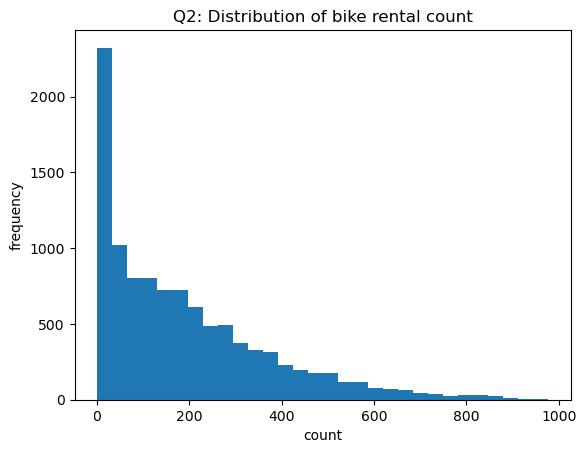

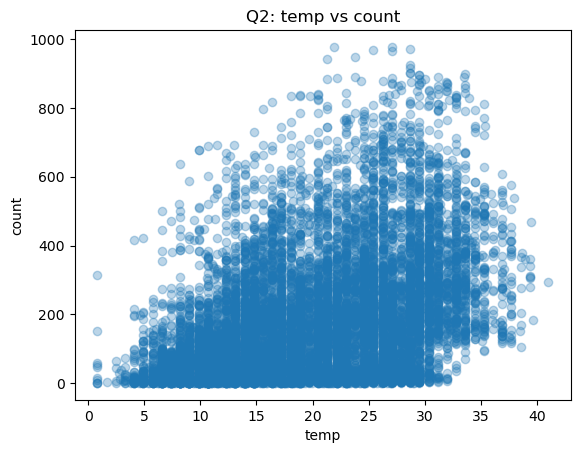

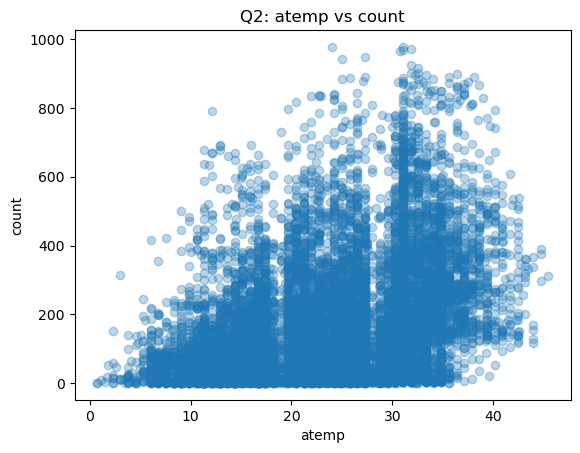

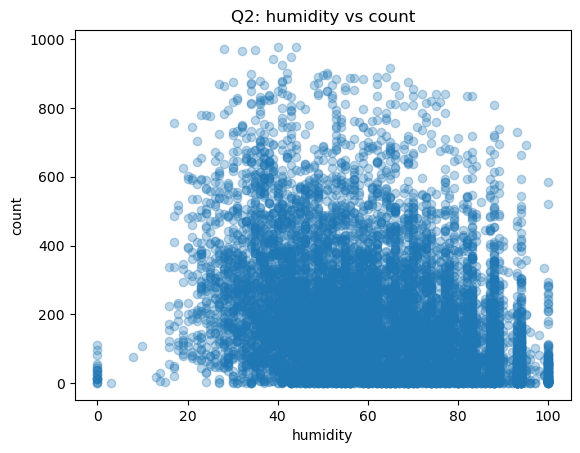

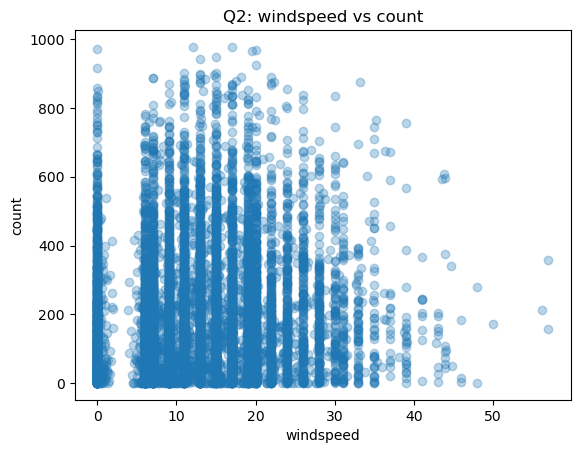

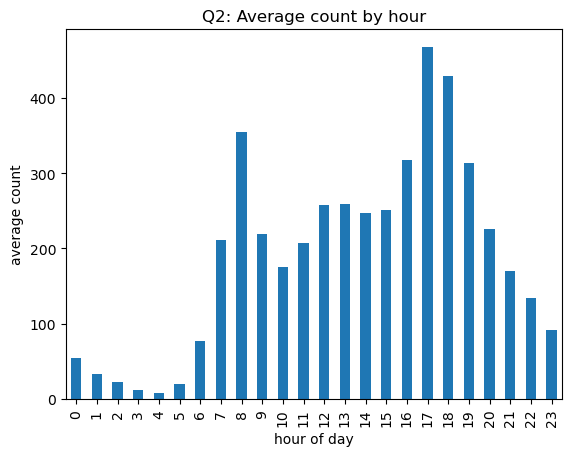

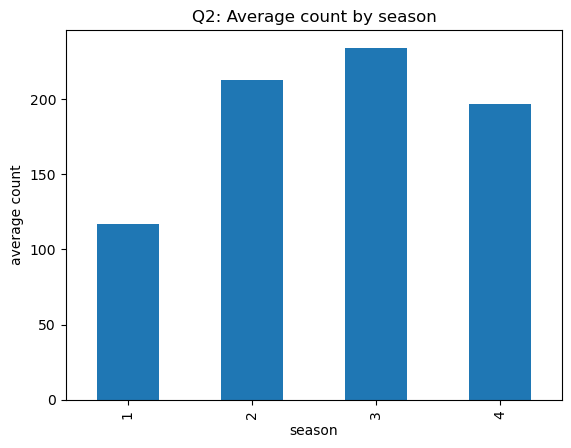


Q4: Feature matrix shape after encoding: (10450, 53)

Train size: 8360 Validation size: 2090

Q5: Baseline Linear Regression RMSLE: 1.1349861492846605
Q6: Polynomial feature shapes: (8360, 106) (2090, 106)

Q6/Q7: Ridge Regression results:
  Ridge λ=0.1: RMSLE=1.13979
  Ridge λ=1: RMSLE=1.13637
  Ridge λ=10: RMSLE=1.12095
  Ridge λ=30: RMSLE=1.11860
  Ridge λ=50: RMSLE=1.11002
  Ridge λ=100: RMSLE=1.10080
Best Ridge λ: 100 Best Ridge RMSLE: 1.1007966400395588

Q6/Q7: Lasso Regression results:
  Lasso λ=0.0001: RMSLE=1.24807
  Lasso λ=0.001: RMSLE=1.24802
  Lasso λ=0.01: RMSLE=1.24759
  Lasso λ=0.1: RMSLE=1.24349

Q7: Model comparison summary (you can turn this into a table in the report):
  Linear Regression (no poly): RMSLE = 1.13499
  Best Ridge (degree=2, λ=100): RMSLE = 1.10080
  Lasso (degree=2, λ=0.0001): RMSLE = 1.24807
  Lasso (degree=2, λ=0.001): RMSLE = 1.24802
  Lasso (degree=2, λ=0.01): RMSLE = 1.24759
  Lasso (degree=2, λ=0.1): RMSLE = 1.24349


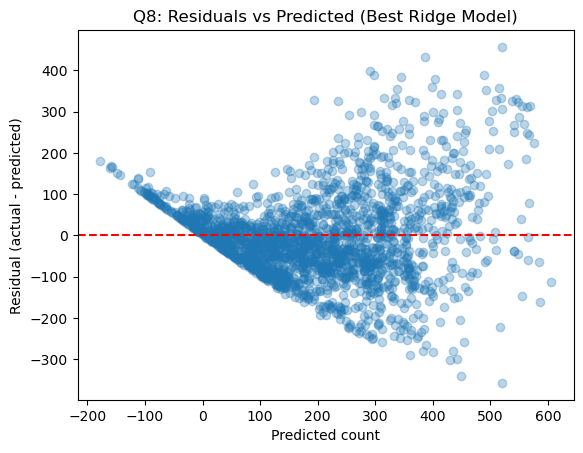

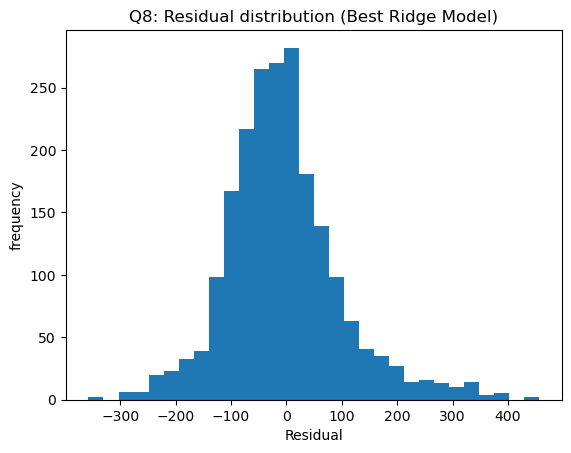


submission.csv file saved – upload this to Kaggle/leaderboard as required.


In [1]:
# ============================================================
# ML ASSIGNMENT 1 – BIKE SHARING DEMAND (NO SKLEARN)
# One big script with Q1–Q12 task-wise comments
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Helper: RMSLE (given in PDF) – used in Q5, Q6, Q7, Q8
# -----------------------------
def rmsle(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_pred = np.clip(y_pred, 0, None)  # avoid negative predictions
    return np.sqrt(np.mean((np.log1p(y_true) - np.log1p(y_pred))**2))

# -----------------------------
# Load data – used for Q1–Q9
# -----------------------------
train_df = pd.read_csv("bike_train.csv")
test_df  = pd.read_csv("bike_test.csv")

# ============================================================
# Q1: Examine dataset size, missing values, and feature types
# ============================================================

print("Q1: Train shape:", train_df.shape)
print("Q1: Test  shape:", test_df.shape)
print("\nQ1: Train info():")
print(train_df.info())
print("\nQ1: Missing values in train:")
print(train_df.isna().sum())
print("\nQ1: dtypes summary:")
print(train_df.dtypes)

# NOTE: For the written report, you will describe:
#   - rows/columns
#   - which columns are numeric/categorical
#   - whether any column has missing values

# ============================================================
# Basic datetime feature engineering (needed for Q2, Q3, Q4, and models)
# ============================================================

def add_time_features(df):
    df = df.copy()

    # First try ISO (YYYY-MM-DD HH:MM:SS)
    dt1 = pd.to_datetime(df["datetime"], format="%Y-%m-%d %H:%M:%S", errors="coerce")

    # Then try European (DD-MM-YYYY H:MM)
    dt2 = pd.to_datetime(df["datetime"], format="%d-%m-%Y %H:%M", errors="coerce")

    # Combine: use whichever parsed correctly
    df["datetime"] = dt1.fillna(dt2)

    # Check if any still failed
    if df["datetime"].isna().any():
        print("WARNING: Some datetime values could not be parsed at all.")

    df["hour"]     = df["datetime"].dt.hour
    df["weekday"]  = df["datetime"].dt.weekday
    df["month"]    = df["datetime"].dt.month
    df["year"]     = df["datetime"].dt.year

    return df

train_df = add_time_features(train_df)
test_df  = add_time_features(test_df)

# ============================================================
# Q2: Visualize relationships between key features and target (count)
# ============================================================

# Distribution of target 'count'
plt.figure()
plt.hist(train_df["count"], bins=30)
plt.title("Q2: Distribution of bike rental count")
plt.xlabel("count")
plt.ylabel("frequency")
plt.show()

# Continuous features vs count (scatter): temp, atemp, humidity, windspeed
for col in ["temp", "atemp", "humidity", "windspeed"]:
    if col in train_df.columns:
        plt.figure()
        plt.scatter(train_df[col], train_df["count"], alpha=0.3)
        plt.title(f"Q2: {col} vs count")
        plt.xlabel(col)
        plt.ylabel("count")
        plt.show()

# Time-based averages: hour vs avg count
plt.figure()
train_df.groupby("hour")["count"].mean().plot(kind="bar")
plt.title("Q2: Average count by hour")
plt.xlabel("hour of day")
plt.ylabel("average count")
plt.show()

# Season vs avg count (if season column exists)
if "season" in train_df.columns:
    plt.figure()
    train_df.groupby("season")["count"].mean().plot(kind="bar")
    plt.title("Q2: Average count by season")
    plt.xlabel("season")
    plt.ylabel("average count")
    plt.show()

# NOTE: In the report for Q2, you will explain these plots in words.

# ============================================================
# Q3: Suggest which variables are most informative – discussion
# ============================================================
# Q3 is mainly theory; use plots above to argue that:
#   - hour, season, temperature, workingday, weather, etc., are important.
# There is no extra code required for Q3 beyond the EDA already done.

# ============================================================
# Q4: Feature Engineering – datetime features + one-hot encoding
# ============================================================
# We now do the main feature engineering used by the models.

cat_cols = ["season", "weather", "holiday", "workingday",
            "hour", "weekday", "month", "year"]

def one_hot(df, col):
    """
    Manual one-hot encoding (no sklearn):
    Creates binary columns for each category except first (drop-first).
    """
    df = df.copy()
    values = sorted(df[col].unique())
    for v in values[1:]:
        df[f"{col}_{v}"] = (df[col] == v).astype(int)
    df = df.drop(columns=[col])
    return df

# Combine train and test so that encoding is consistent across both
train_rows = len(train_df)
combined = pd.concat([train_df, test_df], axis=0, ignore_index=True)

for c in cat_cols:
    combined = one_hot(combined, c)

train_enc = combined.iloc[:train_rows].copy()
test_enc  = combined.iloc[train_rows:].copy()

# Build X, y, X_test after feature engineering
drop_cols = ["datetime", "casual", "registered", "count"]
X_cols = [c for c in train_enc.columns if c not in drop_cols]

X      = train_enc[X_cols].values.astype(float)      # features (train)
y      = train_enc["count"].values.reshape(-1, 1)    # target (train)
X_test = test_enc[X_cols].values.astype(float)       # features (test)

print("\nQ4: Feature matrix shape after encoding:", X.shape)

# NOTE: For Q4 write-up, explain that you:
#   - extracted hour/weekday/month/year
#   - encoded categorical variables with one-hot
#   - dropped casual/registered from features

# ============================================================
# Helper: train/validation split (no sklearn) – used in Q5–Q9
# ============================================================

def train_val_split(X, y, test_size=0.2):
    n = X.shape[0]
    split = int(n * (1 - test_size))
    X_train = X[:split]
    X_val   = X[split:]
    y_train = y[:split]
    y_val   = y[split:]
    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = train_val_split(X, y, test_size=0.2)

print("\nTrain size:", X_train.shape[0], "Validation size:", X_val.shape[0])

# ============================================================
# Q5: Simple Linear Regression model on train/validation split
# ============================================================

def lin_fit(X, y):
    Xb = np.hstack([np.ones((X.shape[0], 1)), X])      # add bias
    theta = np.linalg.pinv(Xb.T @ Xb) @ (Xb.T @ y)     # normal equation
    return theta

def lin_pred(X, theta):
    Xb = np.hstack([np.ones((X.shape[0], 1)), X])      # add bias
    return Xb @ theta

theta_lin = lin_fit(X_train, y_train)
y_val_pred_lin = lin_pred(X_val, theta_lin)
rmsle_lin = rmsle(y_val, y_val_pred_lin)
print("\nQ5: Baseline Linear Regression RMSLE:", rmsle_lin)

# ============================================================
# Q6: Polynomial features + Ridge & Lasso regression (no sklearn)
# ============================================================

# ---- Polynomial features (degree = 2) ----
def poly_features(X, degree=2):
    """
    Polynomial features up to degree 2:
      [x1, x2, ..., x1^2, x2^2, ...]
    (No interaction terms, enough for assignment.)
    """
    X = np.asarray(X)
    if degree == 1:
        return X
    parts = [X]
    if degree >= 2:
        parts.append(X**2)
    return np.concatenate(parts, axis=1)

degree = 2
X_train_poly = poly_features(X_train, degree)
X_val_poly   = poly_features(X_val,   degree)
X_full_poly  = poly_features(X,       degree)
X_test_poly  = poly_features(X_test,  degree)

print("Q6: Polynomial feature shapes:", X_train_poly.shape, X_val_poly.shape)

# ---- Ridge Regression (closed-form) ----
def ridge_fit(X, y, lam):
    """
    Ridge Regression:
      theta = (X^T X + λI)^(-1) X^T y
    Bias term (first parameter) is NOT regularized.
    """
    Xb = np.hstack([np.ones((X.shape[0], 1)), X])
    n = Xb.shape[1]
    I = np.eye(n)
    I[0, 0] = 0  # do not regularize bias
    theta = np.linalg.pinv(Xb.T @ Xb + lam * I) @ (Xb.T @ y)
    return theta

def ridge_pred(X, theta):
    Xb = np.hstack([np.ones((X.shape[0], 1)), X])
    return Xb @ theta

lambdas = [0.1, 1, 10, 30, 50, 100]
best_ridge_rmsle = None
best_ridge_lam = None
best_ridge_theta = None

print("\nQ6/Q7: Ridge Regression results:")
for lam in lambdas:
    theta_ridge = ridge_fit(X_train_poly, y_train, lam)
    y_val_pred_ridge = ridge_pred(X_val_poly, theta_ridge)
    score = rmsle(y_val, y_val_pred_ridge)
    print(f"  Ridge λ={lam}: RMSLE={score:.5f}")
    if (best_ridge_rmsle is None) or (score < best_ridge_rmsle):
        best_ridge_rmsle = score
        best_ridge_lam = lam
        best_ridge_theta = theta_ridge

print("Best Ridge λ:", best_ridge_lam, "Best Ridge RMSLE:", best_ridge_rmsle)

# ---- Lasso Regression (gradient descent with L1, on scaled poly features) ----
# Scale polynomial features for stability (zero mean, unit std)
X_train_poly_l = X_train_poly.copy()
X_val_poly_l   = X_val_poly.copy()

mean_poly = X_train_poly_l.mean(axis=0, keepdims=True)
std_poly  = X_train_poly_l.std(axis=0, keepdims=True) + 1e-8

X_train_poly_l = (X_train_poly_l - mean_poly) / std_poly
X_val_poly_l   = (X_val_poly_l   - mean_poly) / std_poly

def lasso_fit(X, y, lam, lr=1e-3, epochs=2000):
    """
    Lasso Regression via gradient descent:
      minimize (1/(2m))||Xbθ - y||^2 + λ * ||θ||_1
    Bias term is not regularized.
    """
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float).reshape(-1, 1)
    Xb = np.hstack([np.ones((X.shape[0], 1)), X])
    m, n = Xb.shape
    theta = np.zeros((n, 1), dtype=float)

    for _ in range(epochs):
        y_pred = Xb @ theta
        grad = (Xb.T @ (y_pred - y)) / m
        # gradient clipping to avoid explosion
        norm = np.linalg.norm(grad)
        if norm > 1e3:
            grad = grad * (1e3 / norm)
        sign = np.sign(theta)
        sign[0] = 0  # don't regularize bias
        theta -= lr * (grad + lam * sign)

    return theta

def lasso_pred(X, theta):
    X = np.asarray(X, dtype=float)
    Xb = np.hstack([np.ones((X.shape[0], 1)), X])
    return Xb @ theta

print("\nQ6/Q7: Lasso Regression results:")
lasso_results = []
for lam in [0.0001, 0.001, 0.01, 0.1]:
    theta_lasso = lasso_fit(X_train_poly_l, y_train, lam=lam, lr=1e-3, epochs=2000)
    y_val_pred_lasso = lasso_pred(X_val_poly_l, theta_lasso)
    score = rmsle(y_val, y_val_pred_lasso)
    lasso_results.append((lam, score))
    print(f"  Lasso λ={lam}: RMSLE={score:.5f}")

# ============================================================
# Q7: Summarize all results in one "table" (printed)
# ============================================================

print("\nQ7: Model comparison summary (you can turn this into a table in the report):")
print(f"  Linear Regression (no poly): RMSLE = {rmsle_lin:.5f}")
print(f"  Best Ridge (degree=2, λ={best_ridge_lam}): RMSLE = {best_ridge_rmsle:.5f}")
for lam, score in lasso_results:
    print(f"  Lasso (degree=2, λ={lam}): RMSLE = {score:.5f}")

# ============================================================
# Q8: Plot residuals for the best model (use best Ridge here)
# ============================================================

y_val_pred_best = ridge_pred(X_val_poly, best_ridge_theta)
residuals = y_val - y_val_pred_best

plt.figure()
plt.scatter(y_val_pred_best, residuals, alpha=0.3)
plt.axhline(0, color="red", linestyle="--")
plt.title("Q8: Residuals vs Predicted (Best Ridge Model)")
plt.xlabel("Predicted count")
plt.ylabel("Residual (actual - predicted)")
plt.show()

plt.figure()
plt.hist(residuals, bins=30)
plt.title("Q8: Residual distribution (Best Ridge Model)")
plt.xlabel("Residual")
plt.ylabel("frequency")
plt.show()

# ============================================================
# Q9: Explain why the winning model performs better – theory
# ============================================================
# Q9 is a written explanation in your report, using:
#   - results printed in Q7
#   - residual plots in Q8
# Generally: polynomial + regularization captures nonlinear patterns
# better than simple linear regression while controlling overfitting.

# ============================================================
# Q10, Q11, Q12: Reflection (theory only, no extra code)
# ============================================================
# Q10: RMSLE vs RMSE – explain using the log scale and relative errors.
# Q11: Trade-off between simplicity (linear) and predictive power (poly + regularization).
# Q12: Why plain Linear Regression struggles with time-of-day patterns (nonlinear, cyclic).

# ============================================================
# FINAL STEP: Train best model on full training data & create submission.csv
# ============================================================

# Refit best Ridge model (degree=2) on all training data
theta_final = ridge_fit(X_full_poly, y, best_ridge_lam)
test_pred_full = ridge_pred(X_test_poly, theta_final)
test_pred_full = np.clip(test_pred_full, 0, None)

submission = pd.DataFrame({"count": test_pred_full.ravel()})
submission.to_csv("submission.csv", index=False)
print("\nsubmission.csv file saved – upload this to Kaggle/leaderboard as required.")
